<a href="https://colab.research.google.com/github/MakhovaAnastasia/Paper_Fuzzy_LSTM/blob/main/LSTM.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

***Обычный LSTM для прогнозирования цен.***

Импортируем нужные библиотеки

In [ ]:
import pandas as pd
from keras.layers import Dense, Activation, Dropout
from keras.layers import LSTM, Input
from keras.models import Sequential
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics  import mean_squared_error
import math
import numpy as np
import matplotlib.pyplot as plt
import yfinance as yf
from datetime import date,timedelta
import sklearn.metrics
import tensorflow as tf
from sklearn.metrics import mean_squared_error, mean_absolute_error, explained_variance_score, r2_score,mean_absolute_percentage_error
from keras.utils import get_custom_objects
import time
from prettytable import PrettyTable

Собираем данные на разных тенорах

In [ ]:
def get_historical_close_data(name,step):
  if step=='1d':
    start = '2018-01-01'
    end = '2024-02-15'
    data = yf.Ticker(name)
    data=data.history(start=start, end=end,interval ='1d')
    data.reset_index(inplace=True)
    data = data.loc[:,('Date','Close')]
    data = data.sort_index(ascending = False)
    return data
  if step=='1h':
    start = '2023-01-01'
    end = '2024-02-15'
    data = yf.Ticker(name)
    data=data.history(start=start, end=end,interval ='1h')
    data.reset_index(inplace=True)
    data = data.loc[:,('Datetime','Close')]
    data = data.sort_index(ascending = False)
    return data
  if step=='1m':
    start = date.today()-timedelta(days=7)
    end = date.today()
    data = yf.Ticker(name)
    data=data.history(start=start, end=end,interval ='1m')
    data.reset_index(inplace=True)
    return data

Нормализация данных и денормализация

In [ ]:
def normalization(data):
    scaler = MinMaxScaler(feature_range = (0,1))
    data_norm = scaler.fit_transform(data)

    return data_norm

In [ ]:
def de_normalization(data, new_data):
    scaler = MinMaxScaler(feature_range = (0,1))
    scaler.fit_transform(data)
    unormalized = scaler.inverse_transform(new_data)

    return unormalized

Разбиваем данные на тренировочную и тестовую выборку и преобразуем их в нужный для LSTM формат

In [ ]:
def split_train_test(data):

    # split into train and test sets
    train_size = int(len(data) * 0.75)
    train, test = data[0:train_size,], data[train_size:len(data),]
    return train, test

def create_dataset(dataset, lookback):
    dataX, dataY = [], []
    for i in range(len(dataset)-lookback-1):
      a = dataset[i:(i+lookback), 0]
      dataX.append(a)
      dataY.append(dataset[i + lookback, 0])
    return np.array(dataX), np.array(dataY)

Так как в LSTM базовая функция активации -- tanh, по результатам прошлых лет выбираем следующие параметры:

In [ ]:
step= '1m'
unit = 16
companies = 'BTC-USD'
lookback=30

Подготавливаем данные: скачиваем, нормализуем, формируем выборки

In [ ]:
dataset = get_historical_close_data(companies,step)
scaler=MinMaxScaler(feature_range=(0,1))
dataset_norm=scaler.fit_transform(np.array(dataset['Close'].values).reshape(-1,1))
train_dataset, test_dataset = split_train_test(dataset_norm)
train_X, train_y = create_dataset(train_dataset, lookback)
test_X, test_y = create_dataset(test_dataset,lookback)


train_X =train_X.reshape(train_X.shape[0],train_X.shape[1] , 1)
test_X = test_X.reshape(test_X.shape[0],test_X.shape[1] , 1)


Запускаем обучение LSTM с функцией потерь MSE и алгоритмом оптимизации ADAM

In [ ]:
model=Sequential()
model = Sequential()
model.add(Input(shape=(lookback,1)))  # Вот так правильно
model.add(LSTM(unit))
model.add(Dense(1))
model.compile(loss='mean_squared_error',optimizer='adam')
start_time = time.time()
result=model.fit(train_X,train_y,validation_data=(test_X,test_y),epochs=100,batch_size=32,verbose=False)
end_time = time.time()
train_timing=(end_time-start_time)

In [ ]:
print(f"time = {train_timing}")

time = 249.61397790908813


Делаем прогноз на тренировочной и тестовой выборке

In [ ]:
train_predict=model.predict(train_X)
start_time = time.time()
test_predict=model.predict(test_X)
end_time = time.time()
test_timing=(end_time-start_time)
#train_predict.shape, test_predict.shape
print(f"time = {test_timing}")

175/175 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step
58/58 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
time = 0.36344289779663086


Возвращаем данные в исходные единицы измерения

In [ ]:

train_predict = scaler.inverse_transform(train_predict)
test_predict = scaler.inverse_transform(test_predict)
original_ytrain = scaler.inverse_transform(train_y.reshape(-1,1))
original_ytest = scaler.inverse_transform(test_y.reshape(-1,1))

График с оригинальными данными и прогнозами:

In [ ]:
trainPredictPlot = np.empty_like(dataset_norm)
trainPredictPlot[:, ] = np.nan
trainPredictPlot[lookback:len(train_predict)+lookback, ] = train_predict[:,0].reshape(-1,1)
testPredictPlot = np.empty_like(dataset_norm)
testPredictPlot[:,] = np.nan
testPredictPlot[len(train_predict)+(lookback*2)+1:len(dataset['Close'])-1, ] = test_predict[:,0].reshape(-1,1)



In [ ]:
plt.style.use('https://github.com/dhaitz/matplotlib-stylesheets/raw/master/pitayasmoothie-light.mplstyle')
%matplotlib inline

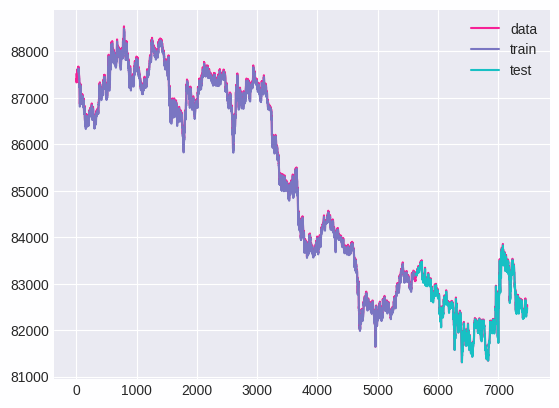

In [ ]:
plt.plot(de_normalization(dataset['Close'].values.reshape(-1,1),dataset_norm),color = 'C2', label = 'data')
plt.plot(trainPredictPlot,color = 'C0', label = 'train')
plt.plot(testPredictPlot,color = 'C3', label = 'test')
plt.legend()
plt.show()

Метрики:

In [ ]:
rmse_train= math.sqrt(mean_squared_error(original_ytrain,train_predict))
mae_train=mean_absolute_error(original_ytrain,train_predict)
mape_train=mean_absolute_percentage_error(original_ytrain,train_predict)
rmse_test=math.sqrt(mean_squared_error(original_ytest,test_predict))
mae_test=mean_absolute_error(original_ytest,test_predict)
mape_test=mean_absolute_percentage_error(original_ytest,test_predict)

my_table = PrettyTable()
my_table.field_names = [f"RESULTS", "TRAIN", "TEST"]
my_table.add_row(["rmse", rmse_train, rmse_test])
my_table.add_row(["mae", mae_train, mae_test])
my_table.add_row(["mape",mape_train, mape_test])

print(my_table)


+---------+-----------------------+-----------------------+
| RESULTS |         TRAIN         |          TEST         |
+---------+-----------------------+-----------------------+
|   rmse  |    59.0920947117681   |   60.67359111268917   |
|   mae   |   46.979733439404804  |   43.137876393420335  |
|   mape  | 0.0005465629538569222 | 0.0005224758204890548 |
+---------+-----------------------+-----------------------+


График функций потерь:

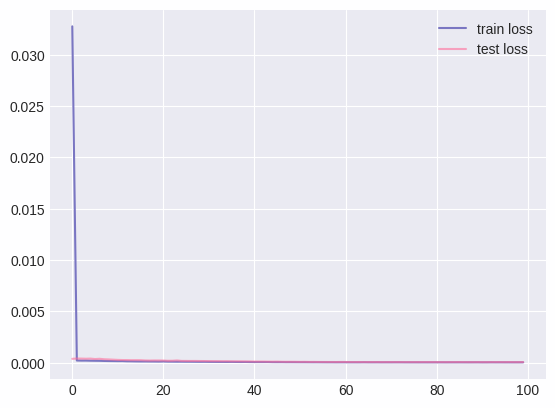

In [ ]:
plt.plot(result.history['loss'],label = 'train loss')
plt.plot(result.history['val_loss'],label = 'test loss')
plt.legend()
plt.show()